/tmp/SLURM_2644516/ipykernel_276570/2248346891.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(station_col).apply(lambda g: np.sqrt(((g[obs_col] - g[model_col])**2).mean()))
/tmp/SLURM_2644516/ipykernel_276570/2248346891.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(station_col).apply(lambda g: np.sqrt(((g[obs_col] - g[model_col])**2).mean()))
/tmp/SLURM_26445

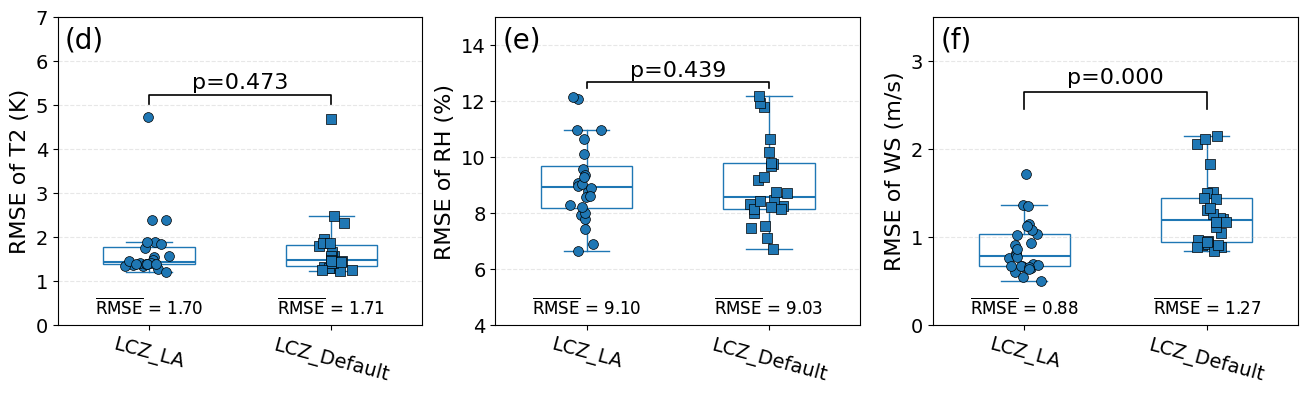

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon
from matplotlib.ticker import MaxNLocator
from matplotlib import transforms  


def compute_station_rmse(csv_path, obs_col='T2_Obs', model_col='T2_model', station_col='StationID'):
    df = pd.read_csv(csv_path).dropna(subset=[obs_col, model_col, station_col])
    return df.groupby(station_col).apply(lambda g: np.sqrt(((g[obs_col] - g[model_col])**2).mean()))

if __name__ == "__main__":
    groups = [
        {
            'files': [
                ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_T2_LCZ_LA_Summer.csv',    'LCZ LA (Summer)'),
                ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_T2_LCZ_Default_Summer.csv','LCZ Default (Summer)'),
            ],
            'ylabel': 'RMSE of T2 (K)'
        },
        {
            'files': [
                ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_RH_LCZ_LA_Summer.csv',    'LCZ LA (Summer)'),
                ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_RH_LCZ_Default_Summer.csv','LCZ Default (Summer)'),
            ],
            'ylabel': 'RMSE of RH (%)'
        },
        {
            'files': [
                ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_WS_LCZ_LA_Summer.csv',    'LCZ LA (Summer)'),
                ('/project2/zhan248_1326/hhao4018/Model_Evaluation/model_obs_pairs_WS_LCZ_Default_Summer.csv','LCZ Default (Summer)'),
            ],
            'ylabel': 'RMSE of WS (m/s)'
        }
    ]

    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 16,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
    })

    summer_color = 'C0'
    winter_color = 'C0'
    marker_map = {'LCZ LA':'o','LCZ Default':'s'}
    letters = ['(d)','(e)','(f)']

    fig, axes = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={'wspace':0.2})

    for i, group in enumerate(groups):
        ax = axes[i]

        rmse_dict = {label: compute_station_rmse(path)
                     for path,label in group['files']}
        labels = list(rmse_dict.keys())
        x = np.arange(len(labels))

        for xi, label in zip(x, labels):
            season = 'Summer' if 'Summer' in label else 'Winter'
            color  = summer_color if season=='Summer' else winter_color
            ax.boxplot(rmse_dict[label].values,
                       positions=[xi], widths=0.5,
                       patch_artist=True, showfliers=False,
                       boxprops=dict(facecolor='none', edgecolor=color),
                       whiskerprops=dict(color=color),
                       capprops=dict(color=color),
                       medianprops=dict(color=color, linewidth=1.5),
                       zorder=1)
            y = rmse_dict[label].values
            jitter = np.random.normal(loc=xi, scale=0.05, size=len(y))

            ax.scatter(jitter, y, c=color,
                       marker=marker_map[label.split(' (')[0]],
                       edgecolor='k', linewidth=0.5,
                       zorder=2, s=50)

            means = [np.nanmean(rmse_dict[label].values) for label in labels]
            
            trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
            for xi, m in zip(x, means):
                ax.text(xi, 0.02, rf"$\overline{{\mathrm{{RMSE}}}}$ = {m:.2f}", transform=trans,
                        ha='center', va='bottom', fontsize=12,
                        bbox=dict(boxstyle='round,pad=0.15', facecolor='white', edgecolor='none', alpha=0.7))

        for season, base in [('Summer',0)]:
            a = rmse_dict[f'LCZ LA ({season})']
            b = rmse_dict[f'LCZ Default ({season})']
            common = a.index.intersection(b.index)
            d1, d2 = a.loc[common], b.loc[common]
            p_val = wilcoxon(d1, d2).pvalue
            y_max = max(d1.max(), d2.max()) + 0.5
            x0, x1 = base, base+1
            ax.plot([x0, x0, x1, x1], [y_max-0.2, y_max, y_max, y_max-0.2],
                    'k-', lw=1.2)
            ax.text((x0+x1)/2, y_max+0.05, f"p={p_val:.3f}",
                    ha='center', va='bottom')

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['LCZ_LA', 'LCZ_Default'], rotation=-15)
        ax.set_ylabel(group['ylabel'])
        ax.text(0.02, 0.90, letters[i], transform=ax.transAxes, fontsize=20)
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        y_limits = [
            (0, 7),  
            (4, 15), 
            (0, 3.5)  
        ]
        
        for ax, (ymin, ymax) in zip(axes, y_limits):
            ax.set_ylim(ymin, ymax)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()